In [1]:
import numpy as np
import matplotlib
import os
import cellpose
import tifffile
from cellpose import plot
from tqdm.notebook import tqdm
import glob
import matplotlib.pyplot as plt

import graphsonchip
import graphsonchip.analyse

from random import random
import random
import skimage.color
from skimage.segmentation import find_boundaries

# Example analysis pipeline

## Reconstructing the complete image

In [2]:
PATH = '/home/pub/Documents/mnt/Gustave/light_sheet/Peixoto'

reconstructed_image = np.load(os.path.join(PATH,'210216_4_individual_tile_1_recontructed.npy'))
img = tifffile.imread(os.path.join(PATH,'210216_4_individual_tile_1.tif' ))
img = np.swapaxes(img, 1,3)


In [3]:
img_masked_cellpose = cellpose.plot.mask_overlay(img[10, 100:400, 100:400, 0], reconstructed_image[10, 100:400, 100:400])

In [236]:
img_masked_cellpose = []

for img_or, img_seg in tqdm(zip(img[10:20,..., 0], reconstructed_image[10:20])):

    img_masked_cellpose.append(cellpose.plot.mask_overlay(img_or, img_seg))

0it [00:00, ?it/s]

IndexError: tuple index out of range

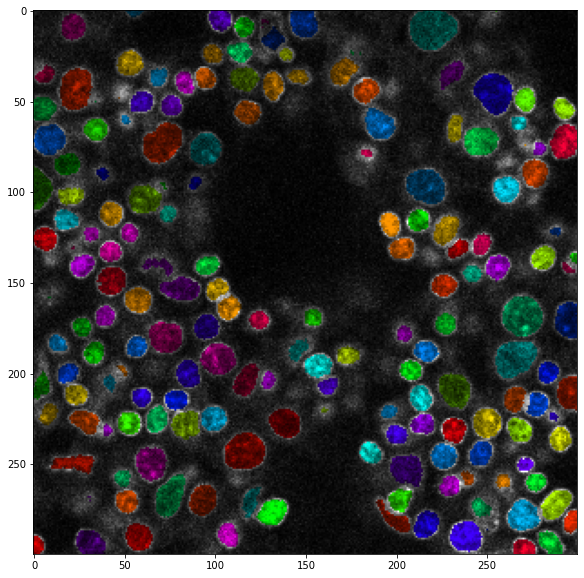

In [4]:
fig, ax = plt.subplots(figsize = (10,10))

plt.imshow(img_masked_cellpose)

## Extracting the cell properties

In [14]:
PATH = '/home/pub/Documents/mnt/Gustave/light_sheet/Peixoto'

reconstructed_image = np.load(os.path.join(PATH,'210216_4_individual_tile_1_recontructed.npy'))
img = tifffile.imread(os.path.join(PATH,'210216_4_individual_tile_1.tif' ))

img = np.swapaxes(img, 1,3)

img_test_seg = np.concatenate((img, reconstructed_image[..., np.newaxis].astype(int)), axis =3)

In [20]:
prop = graphsonchip.analyse.cell_property_extraction.get_cell_properties(
    img_test_seg,
    nuclei_channel = 4,
    analyze_fluo_channels = True,
    fluo_channel_analysis_method = 'basic',
    cell_geometry_properties = False,
    radius = 15,
    labeled_voronoi_tesselation = False,
    percentile = 99
    )

We see what probably is some spurious nuclei detection, We choose to remove these nuclei from the analysis.

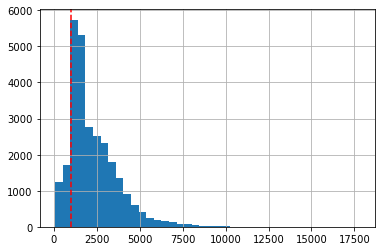

In [21]:
prop.area.hist(bins = 40)
plt.axvline(c = 'r', 
            linestyle = '--',
            x=1000)

In [22]:
prop = prop[prop.area > 700]

### General sample analysis

In [39]:
n_tot = len(prop)

print(n_tot)

25854


In [168]:
from sklearn.cluster import KMeans

X = np.array(prop[['mean_intensity_1', 'mean_intensity_2', 'mean_intensity_3']].values)

kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

prop['cell_type'] = kmeans.labels_

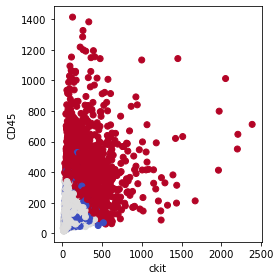

In [169]:
fig, ax = plt.subplots(figsize = (4,4))
plt.scatter(prop['mean_intensity_1'], prop['mean_intensity_2'], marker='o', c=prop['cell_type'], cmap=plt.cm.coolwarm)

ax.set_xlabel('ckit')
ax.set_ylabel('CD45')

plt.tight_layout()

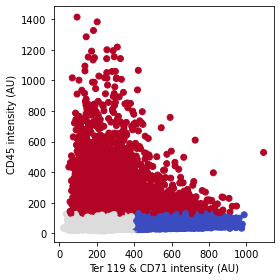

In [192]:
fig, ax = plt.subplots(figsize = (4,4))
plt.scatter(prop['mean_intensity_3'], prop['mean_intensity_2'], marker='o', c=prop['cell_type'], cmap=plt.cm.coolwarm)

ax.set_xlabel('Ter 119 & CD71 intensity (AU)')
ax.set_ylabel('CD45 intensity (AU)')

plt.tight_layout()

In [161]:
prop[prop.cell_type == 2].mean_intensity_2.mean()

435.2845546847271

In [188]:
prop.loc[prop.mean_intensity_2 > 130, 'cell_type'] = 2

In [193]:
n_0 = len(prop[prop.cell_type == 0])

print(n_0)

n_1 = len(prop[prop.cell_type == 1])

print(n_1)

n_2 = len(prop[prop.cell_type == 2])

print(n_2)


n_3 = len(prop[prop.cell_type == 3])

print(n_3)

10719
11869
3266
0


/home/pub/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


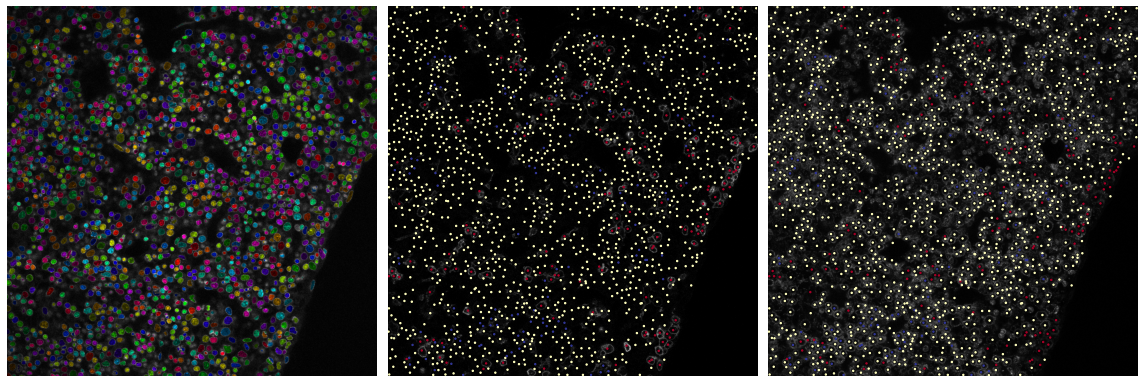

In [190]:
fig, ax = plt.subplots(1,3, figsize = (16,16))

z = 20

minx = 0
maxx = 1000
miny = 0
maxy = 1000

sample_plot = prop[(prop.cell_type > -1) &
                   (prop.z > z - 10) & (prop.z < z + 10) &
                   (prop.x > minx) & (prop.x < maxx) &
                   (prop.y > miny) & (prop.y < maxy)]

sample_plot.x -= minx
sample_plot.y -= miny


ax[0].imshow(cellpose.plot.mask_overlay(img_test_seg[z, minx:maxx, miny:maxy, 0], img_test_seg[z, minx:maxx, miny:maxy,4]))
ax[0].axis('off')

ax[1].imshow(img_test_seg[z, minx:maxx, miny:maxy,2], cmap = 'gray')
ax[1].scatter(sample_plot.y, sample_plot.x, c = sample_plot.cell_type, cmap = 'RdYlBu_r',s=2)
ax[1].axis('off')

ax[2].imshow(img_test_seg[z, minx:maxx, miny:maxy,3], cmap = 'gray')
ax[2].scatter(sample_plot.y, sample_plot.x, c = sample_plot.cell_type, cmap = 'RdYlBu_r',s=2)
ax[2].axis('off')

plt.tight_layout()

plt.savefig('voronoi_pipeline_results.pdf', dpi = 800)

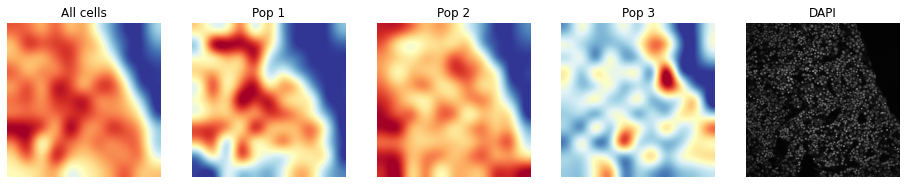

In [191]:
fig, ax = plt.subplots(1,5, figsize = (16,4))

data = prop

nx,ny = 12,12
x_bins = np.linspace(0,1024,nx)
y_bins = np.linspace(0,1024,ny)

X_vals = data.x.values
Y_vals = data.y.values
density, _, _ = np.histogram2d(X_vals,Y_vals,[x_bins,y_bins])

ax[0].imshow(density, 
           interpolation= 'spline36', 
           alpha=1, 
           cmap = 'RdYlBu_r', 
           origin='lower')
ax[0].axis('off')
ax[0].title.set_text('All cells')



data = prop[prop.cell_type == 0]
X_vals = data.x.values
Y_vals = data.y.values
density, _, _ = np.histogram2d(X_vals,Y_vals,[x_bins,y_bins])

ax[1].imshow(density, 
           interpolation= 'spline36', 
           alpha=1, 
           cmap = 'RdYlBu_r', 
           origin='lower')
ax[1].axis('off')
ax[1].title.set_text('Pop 1')


data = prop[prop.cell_type == 1]
X_vals = data.x.values
Y_vals = data.y.values
density, _, _ = np.histogram2d(X_vals,Y_vals,[x_bins,y_bins])

ax[2].imshow(density, 
           interpolation= 'spline36', 
           alpha=1, 
           cmap = 'RdYlBu_r', 
           origin='lower')
ax[2].axis('off')
ax[2].title.set_text('Pop 2')


data = prop[prop.cell_type == 2]
X_vals = data.x.values
Y_vals = data.y.values
density, _, _ = np.histogram2d(X_vals,Y_vals,[x_bins,y_bins])

ax[3].imshow(density, 
           interpolation= 'spline36', 
           alpha=1, 
           cmap = 'RdYlBu_r', 
           origin='lower')
ax[3].axis('off')
ax[3].title.set_text('Pop 3')


ax[4].imshow(img_test_seg[z, ...,0], cmap = 'gray', origin = 'lower')
ax[4].axis('off')
ax[4].title.set_text('DAPI')

<ipython-input-122-ae019ffd729f>:19: RuntimeWarning: invalid value encountered in true_divide
  rel_density = density/density_all
<ipython-input-122-ae019ffd729f>:37: RuntimeWarning: invalid value encountered in true_divide
  rel_density = density/density_all
<ipython-input-122-ae019ffd729f>:55: RuntimeWarning: invalid value encountered in true_divide
  rel_density = density/density_all


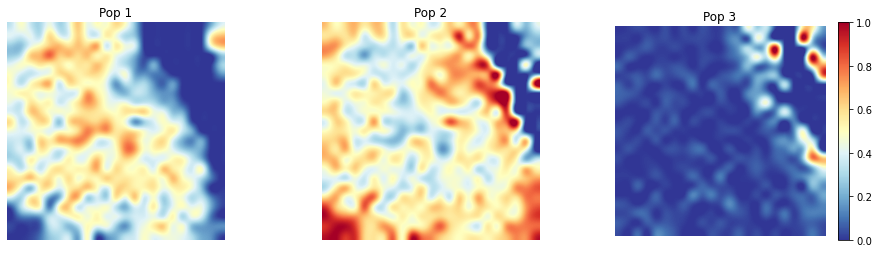

In [122]:
fig, ax = plt.subplots(1,3, figsize = (16,4))

data = prop

nx,ny = 24,24
x_bins = np.linspace(0,1024,nx)
y_bins = np.linspace(0,1024,ny)

X_vals = data.x.values
Y_vals = data.y.values
density_all, _, _ = np.histogram2d(X_vals,Y_vals,[x_bins,y_bins])


data = prop[prop.cell_type == 0]
X_vals = data.x.values
Y_vals = data.y.values
density, _, _ = np.histogram2d(X_vals,Y_vals,[x_bins,y_bins])

rel_density = density/density_all
rel_density[~(rel_density >0)] = 0

ax[0].imshow(rel_density, 
           interpolation= 'spline36', 
           alpha=1, 
           cmap = 'RdYlBu_r', 
           vmin=0, vmax=1,
           origin='lower')
ax[0].axis('off')
ax[0].title.set_text('Pop 1')


data = prop[prop.cell_type == 1]
X_vals = data.x.values
Y_vals = data.y.values
density, _, _ = np.histogram2d(X_vals,Y_vals,[x_bins,y_bins])

rel_density = density/density_all
rel_density[~(rel_density >0)] = 0

ax[1].imshow(rel_density, 
           interpolation= 'spline36', 
           alpha=1, 
           cmap = 'RdYlBu_r',
           vmin=0, vmax=1,
           origin='lower')
ax[1].axis('off')
ax[1].title.set_text('Pop 2')


data = prop[prop.cell_type == 2]
X_vals = data.x.values
Y_vals = data.y.values
density, _, _ = np.histogram2d(X_vals,Y_vals,[x_bins,y_bins])

rel_density = density/density_all
rel_density[~(rel_density >0)] = 0

im = ax[2].imshow(rel_density, 
           interpolation= 'spline36', 
           alpha=1, 
           cmap = 'RdYlBu_r',
           vmin=0, vmax=1,
           origin='lower')
ax[2].axis('off')
ax[2].title.set_text('Pop 3')

fig.colorbar(im)


# Supplementary analysis

Going beyond the simple mean analysis.

## Voronoi segmentation approach

In [ ]:
PATH = '/home/pub/Documents/mnt/Gustave/light_sheet/Peixoto'

reconstructed_image = np.load(os.path.join(PATH,'210216_4_individual_tile_1_recontructed.npy'))
img = tifffile.imread(os.path.join(PATH,'210216_4_individual_tile_1.tif' ))

img = np.swapaxes(img, 1,3)

img_test_seg = np.concatenate((img, reconstructed_image[..., np.newaxis].astype(int)), axis =3)

np.save('img_test_seg.npy', img_test_seg[:50,500:800,500:800,:])

img_test_seg = np.load('img_test_seg.npy')

In [ ]:
prop, voronoi = graphsonchip.analyse.cell_property_extraction.get_cell_properties(
    img_test_seg,
    nuclei_channel = 4,
    analyze_fluo_channels = True,
    fluo_channel_analysis_method = 'local_voronoi',
    cell_geometry_properties = False,
    radius = 15,
    labeled_voronoi_tesselation = False,
    percentile = 99
    )

In [8]:
from sklearn.cluster import KMeans

X = np.array(prop[['percentile_intensity_1', 'percentile_intensity_2', 'percentile_intensity_3']].values)

kmeans = KMeans(n_clusters=4, random_state=0).fit(X)

prop['cell_type'] = kmeans.labels_

KeyError: "None of [Index(['percentile_intensity_1', 'percentile_intensity_2',\n       'percentile_intensity_3'],\n      dtype='object')] are in the [columns]"

In [ ]:
fig, ax = plt.subplots(figsize = (4,4))
plt.scatter(prop['percentile_intensity_3'], prop['percentile_intensity_2'], marker='o', c=prop['cell_type'], cmap=plt.cm.coolwarm)

ax.set_xlabel('Ter 119 & CD71 intensity (AU)')
ax.set_ylabel('CD45 intensity (AU)')

plt.tight_layout()


plt.savefig('classifier_intensities.pdf')

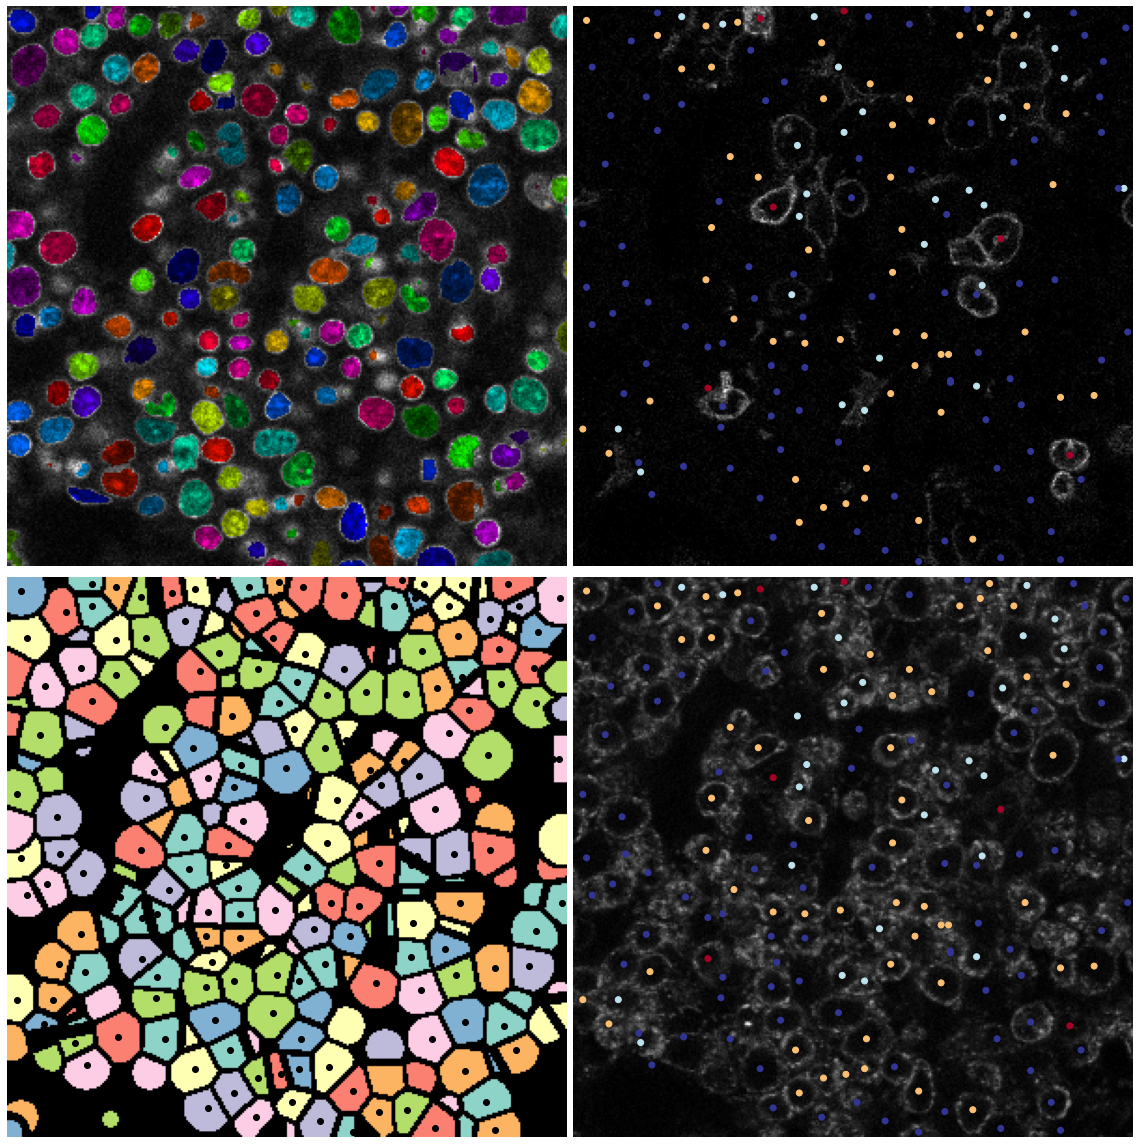

In [55]:
fig, ax = plt.subplots(2,2, figsize = (16,16))

z = 20

sample_plot = prop[(prop.cell_type > -1) &
                   (prop.z > z - 9) & (prop.z < z + 9)]

color_list = [plt.cm.Set3(i) for i in range(8)]
colors = [random.choice(color_list) for i in range(len(np.unique(voronoi[z,:,:])))]
new_map = matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors, N=len(np.unique(voronoi[z,:,:])))

boundary_label_mask = find_boundaries(voronoi, connectivity=2)
vor_copy = np.copy(voronoi)
vor_copy[boundary_label_mask == 1] = 0

ax[0,0].imshow(cellpose.plot.mask_overlay(img_test_seg[z, ...,0], img_test_seg[z, ...,4]))
ax[0, 0].axis('off')

ax[1, 0].imshow(skimage.color.label2rgb(vor_copy[z,:,:],
                                     colors=colors,
                                     bg_label = 0))
ax[1, 0].scatter(sample_plot.y, sample_plot.x, c = 'k')
ax[1, 0].axis('off')

ax[0, 1].imshow(img_test_seg[z, ...,2], cmap = 'gray')
ax[0, 1].scatter(sample_plot.y, sample_plot.x, c = sample_plot.cell_type, cmap = 'RdYlBu_r')
ax[0, 1].axis('off')

ax[1,1].imshow(img_test_seg[z, ...,3], cmap = 'gray')
ax[1,1].scatter(sample_plot.y, sample_plot.x, c = sample_plot.cell_type, cmap = 'RdYlBu_r')
ax[1,1].axis('off')

plt.tight_layout()

plt.savefig('voronoi_pipeline_results.pdf')

# Analyzing the cell cycle tissue

In [181]:
PATH = '/home/pub/Documents/mnt/Gustave/light_sheet/Peixoto/cell_cycle'

reconstructed_image = np.load(os.path.join(PATH,'210303_18_cut.npy'))[:, :2000, :2000]

In [3]:
img = np.swapaxes(tifffile.imread(os.path.join(PATH,'210303_18_cut.tif' )), 1, 3)[:, :2000, :2000, :]

In [3]:
PATH = '/home/pub/Documents/mnt/Gustave/light_sheet/Peixoto/cell_cycle'

total_image = np.concatenate((np.swapaxes(tifffile.imread(os.path.join(PATH,'210303_18_cut.tif' )), 1, 3)[:, :2000, :2000, :], 
                              np.load(os.path.join(PATH,'210303_18_cut.npy'))[:, :2000, :2000, np.newaxis]), 
                             axis = 3)

In [ ]:
del img
del reconstructed_image

In [4]:
tifffile.imsave(os.path.join(PATH,'210303_18_cut_total_image.tif'), total_image)

In [183]:
total_image = tifffile.imread(os.path.join(PATH,'210303_18_cut_total_image.tif'))

In [5]:
prop = graphsonchip.analyse.cell_property_extraction.get_cell_properties(
    total_image,
    nuclei_channel = 3,
    analyze_fluo_channels = True,
    fluo_channel_analysis_method = 'basic',
    cell_geometry_properties = False,
    radius = 15,
    labeled_voronoi_tesselation = False,
    percentile = 99
    )

nuclei properties extracted


In [6]:
prop.to_csv('210303_18_cut_basic.csv')

In [3]:
import pandas
prop = pandas.read_csv('210303_18_cut_basic.csv')

In [4]:
prop = prop[prop.area > 1000]

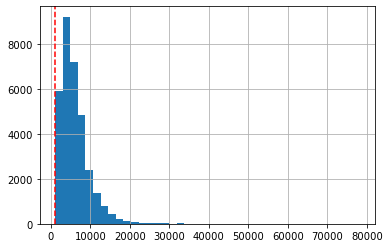

In [5]:
prop.area.hist(bins = 40)
plt.axvline(c = 'r', 
            linestyle = '--',
            x=1000)

In [7]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

prop['log_mean_intensity_0'] = np.log(prop['mean_intensity_0'])
prop['log_mean_intensity_1'] = np.log(prop['mean_intensity_1'])

X = np.array(prop[['mean_intensity_0', 'mean_intensity_1']].values)

kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
gmix = GaussianMixture(n_components=3, random_state=0).fit_predict(X)

prop['cell_type'] = gmix

In [8]:

prop['log_mean_intensity_0'] = np.log(prop['mean_intensity_0'])
prop['log_mean_intensity_1'] = np.log(prop['mean_intensity_1'])
prop.loc[(prop.log_mean_intensity_0 > 4.2) & (prop.log_mean_intensity_1 > 5), 'cell_type'] = 0
prop.loc[(prop.log_mean_intensity_0 < 4.2) & (prop.log_mean_intensity_1 > 5), 'cell_type'] = 1
prop.loc[(prop.log_mean_intensity_0 > 4.2) & (prop.log_mean_intensity_1 < 5), 'cell_type'] = 2
prop.loc[(prop.log_mean_intensity_0 < 4.2) & (prop.log_mean_intensity_1 < 5), 'cell_type'] = 3


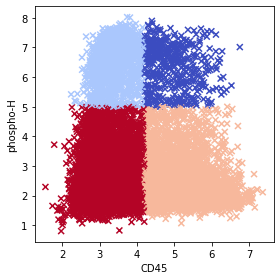

In [9]:
fig, ax = plt.subplots(figsize = (4,4))
plt.scatter(prop['log_mean_intensity_0'], prop['log_mean_intensity_1'], marker='x', c = prop['cell_type'], cmap=plt.cm.coolwarm)

ax.set_xlabel('CD45')
ax.set_ylabel('phospho-H')

plt.tight_layout()

plt.savefig('Intensities.pdf')

NameError: name 'total_image' is not defined

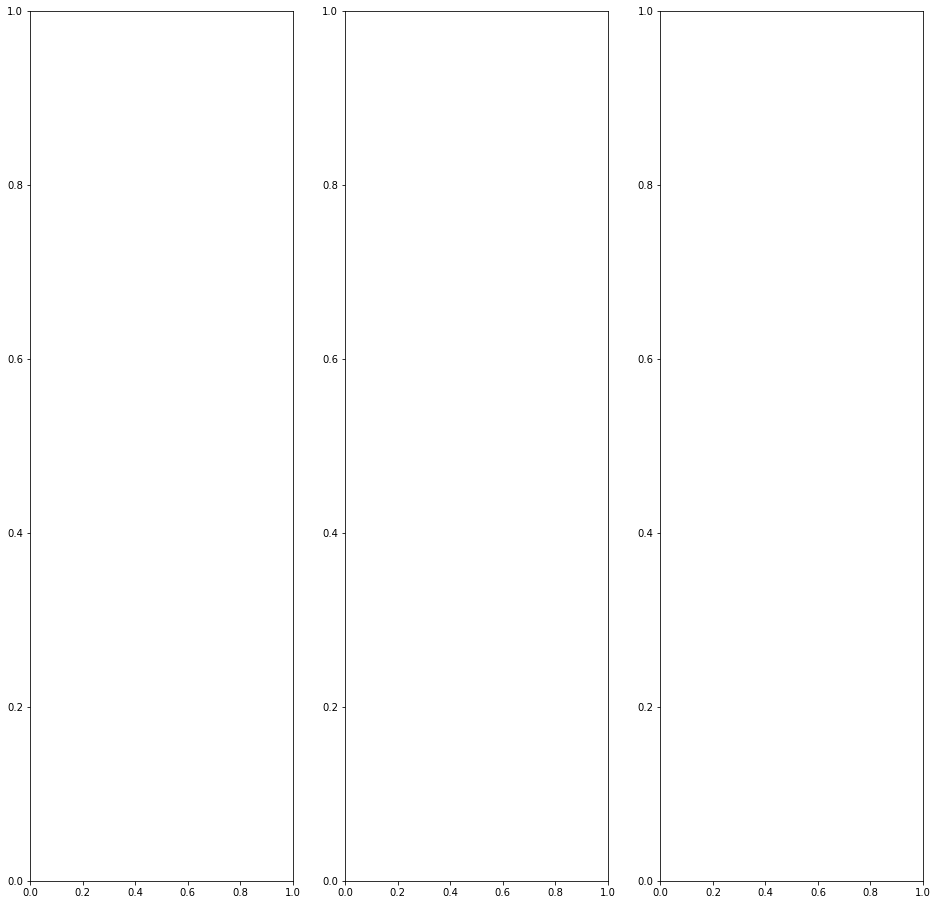

In [10]:
fig, ax = plt.subplots(1,3, figsize = (16,16))

z = 100

sample_plot = prop[(prop.cell_type > -1) &
                   (prop.z > z - 12) & (prop.z < z + 12)&
                   (prop.x > 0) & (prop.x < 400)&
                   (prop.y > 0) & (prop.y < 400)]

img_test_seg = total_image[:, :400, :400, :]

ax[0].imshow(cellpose.plot.mask_overlay(img_test_seg[z, ...,2], img_test_seg[z, ...,3]))
ax[0].scatter(sample_plot.y, sample_plot.x, c = 'r', cmap = 'RdYlBu_r')
ax[0].axis('off')

ax[1].imshow(img_test_seg[z, ...,0], cmap = 'gray')
ax[1].scatter(sample_plot.y, sample_plot.x, c = sample_plot.cell_type, cmap = 'RdYlBu_r')
ax[1].axis('off')

ax[2].imshow(img_test_seg[z, ...,1], cmap = 'gray')
ax[2].scatter(sample_plot.y, sample_plot.x, c = sample_plot.cell_type, cmap = 'RdYlBu_r')
ax[2].axis('off')

plt.tight_layout()

plt.savefig('classification_verification.pdf')

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (16,16))

z = 40

sample_plot = prop[(prop.cell_type > -1) &
                   (prop.z > z - 9) & (prop.z < z + 9)&
                   (prop.x > 0) & (prop.x < 400)&
                   (prop.y > 0) & (prop.y < 400)]

img_test_seg = total_image[:, :400, :400, :]

ax[0].imshow(cellpose.plot.mask_overlay(img_test_seg[z, ...,2], img_test_seg[z, ...,3]))
ax[0].scatter(sample_plot.y, sample_plot.x, c = 'r', cmap = 'RdYlBu_r')
ax[0].axis('off')

ax[1].imshow(img_test_seg[z, ...,0], cmap = 'gray')
ax[1].scatter(sample_plot.y, sample_plot.x, c = sample_plot.cell_type, cmap = 'RdYlBu_r')
ax[1].axis('off')

ax[2].imshow(img_test_seg[z, ...,1], cmap = 'gray')
ax[2].scatter(sample_plot.y, sample_plot.x, c = sample_plot.cell_type, cmap = 'RdYlBu_r')
ax[2].axis('off')

plt.tight_layout()

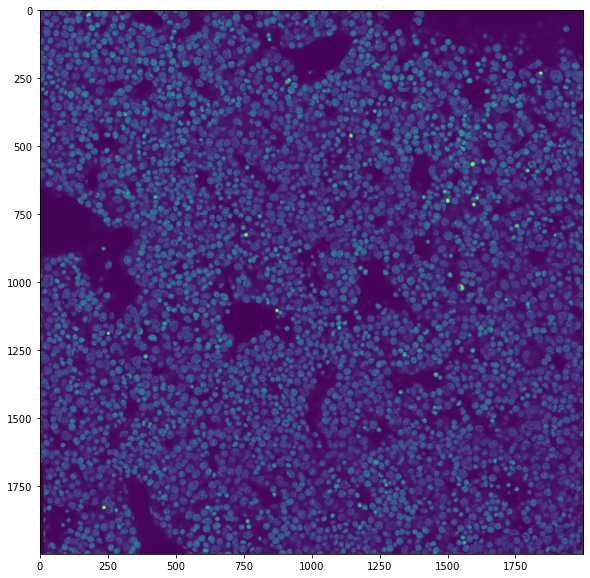

In [45]:
fig, ax  = plt.subplots(figsize = (10,10))
plt.imshow(total_image[10, ..., 2])

In [40]:
n_0 = len(prop[prop.cell_type == 0])

print(n_0)

n_1 = len(prop[prop.cell_type == 1])

print(n_1)

n_2 = len(prop[prop.cell_type == 2])

print(n_2)


n_3 = len(prop[prop.cell_type == 3])

print(n_3)

464
1306
10254
20763


In [41]:
20763/(20763+10254)

0.6694070993326241

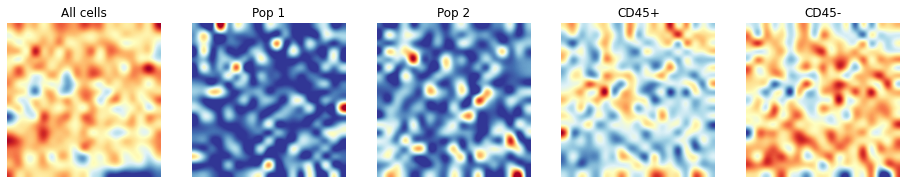

In [42]:
fig, ax = plt.subplots(1,5, figsize = (16,4))

data = prop

nx,ny = 20,20
x_bins = np.linspace(0,2000,nx)
y_bins = np.linspace(0,2000,ny)

X_vals = data.x.values
Y_vals = data.y.values
density_all, _, _ = np.histogram2d(X_vals,Y_vals,[x_bins,y_bins])

ax[0].imshow(density_all, 
           interpolation= 'spline36', 
           alpha=1, 
           cmap = 'RdYlBu_r', 
           origin='lower')
ax[0].axis('off')
ax[0].title.set_text('All cells')



data = prop[prop.cell_type == 0]
X_vals = data.x.values
Y_vals = data.y.values
density, _, _ = np.histogram2d(X_vals,Y_vals,[x_bins,y_bins])

rel_density = density/density_all
rel_density[~(rel_density >0)] = 0

ax[1].imshow(rel_density, 
           interpolation= 'spline36', 
           alpha=1, 
           cmap = 'RdYlBu_r', 
           origin='lower')
ax[1].axis('off')
ax[1].title.set_text('Pop 1')


data = prop[prop.cell_type == 1]
X_vals = data.x.values
Y_vals = data.y.values
density, _, _ = np.histogram2d(X_vals,Y_vals,[x_bins,y_bins])

rel_density = density/density_all
rel_density[~(rel_density >0)] = 0

ax[2].imshow(rel_density, 
           interpolation= 'spline36', 
           alpha=1, 
           cmap = 'RdYlBu_r', 
           origin='lower')
ax[2].axis('off')
ax[2].title.set_text('Pop 2')


data = prop[prop.cell_type == 2]
X_vals = data.x.values
Y_vals = data.y.values
density, _, _ = np.histogram2d(X_vals,Y_vals,[x_bins,y_bins])

rel_density = density/density_all
rel_density[~(rel_density >0)] = 0

ax[3].imshow(rel_density, 
           interpolation= 'spline36', 
           alpha=1, 
           cmap = 'RdYlBu_r', 
           origin='lower')
ax[3].axis('off')
ax[3].title.set_text('CD45+')

data = prop[prop.cell_type == 3]
X_vals = data.x.values
Y_vals = data.y.values
density, _, _ = np.histogram2d(X_vals,Y_vals,[x_bins,y_bins])

rel_density = density/density_all
rel_density[~(rel_density >0)] = 0

ax[4].imshow(rel_density, 
           interpolation= 'spline36', 
           alpha=1, 
           cmap = 'RdYlBu_r', 
           origin='lower')
ax[4].axis('off')
ax[4].title.set_text('CD45-')

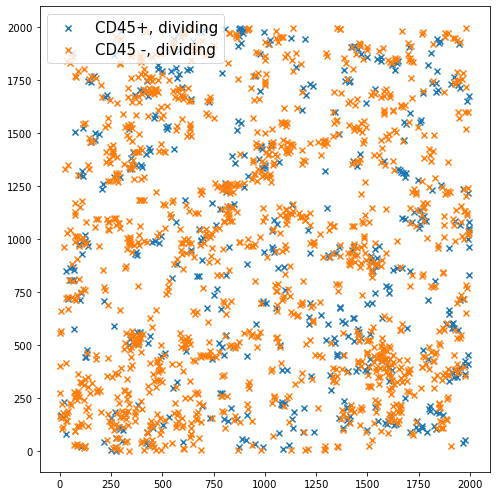

In [23]:
data = prop[prop.cell_type == 0]

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(data['x'], data['y'], marker='x', 
           label = 'CD45+, dividing',
           cmap=plt.cm.coolwarm)

data = prop[prop.cell_type == 1]

ax.scatter(data['x'], data['y'], marker='x',  
           label = 'CD45 -, dividing',
           cmap=plt.cm.coolwarm)

plt.legend(fontsize = 15)

plt.tight_layout()

plt.savefig('dividing.pdf')

In [12]:
from scipy.ndimage import gaussian_filter

In [43]:
density_dividing = np.zeros((2000,2000))

data = prop[(prop.cell_type == 0) | (prop.cell_type == 1)]

for x,y in zip(data.x.values.astype(int), data.y.values.astype(int)):
    
    density_dividing[x,y] += 1
    

filtered_dividing = gaussian_filter(density_dividing, sigma=50)

density_div_hemato = np.zeros((2000,2000))

data = prop[(prop.cell_type == 0)]

for x,y in zip(data.x.values.astype(int), data.y.values.astype(int)):
    
    density_div_hemato[x,y] += 1
    
filtered_div_hemato = gaussian_filter(density_div_hemato, sigma=50)

In [48]:
from scipy import signal
import scipy.signal

corr_div_hemato = scipy.signal.fftconvolve(filtered_div_hemato, filtered_div_hemato, mode='same')
corr_div = scipy.signal.fftconvolve(filtered_dividing, filtered_dividing, mode='same')
corr_cross = scipy.signal.fftconvolve(filtered_dividing, filtered_div_hemato, mode='same')

In [56]:
# create array of radii
x,y = np.meshgrid(np.arange(corr_div_hemato.shape[1]),np.arange(corr_div_hemato.shape[0]))
R = np.sqrt((x-1000)**2+(y-1000)**2)

# calculate the mean
f = lambda r : corr_div_hemato[(R >= r-.5) & (R < r+.5)].mean()
r_div_hemato  = np.linspace(1,500,num=500)
mean_div_hemato = np.vectorize(f)(r_div_hemato)

# calculate the mean
f = lambda r : corr_div[(R >= r-.5) & (R < r+.5)].mean()
r_div  = np.linspace(1,500,num=500)
mean_div = np.vectorize(f)(r_div)

# calculate the mean
f = lambda r : corr_cross[(R >= r-.5) & (R < r+.5)].mean()
r_cross  = np.linspace(1,500,num=500)
mean_cross = np.vectorize(f)(r_cross)

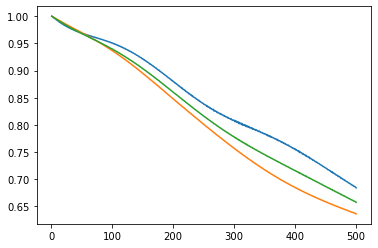

In [58]:
plt.plot(r_div_hemato,mean_div_hemato/max(mean_div_hemato))
plt.plot(r_div,mean_div/max(mean_div))
plt.plot(r_cross,mean_cross/max(mean_cross))

### Making the local tissue network

In [1]:
import numpy as np
import matplotlib
import os
import cellpose
import tifffile
from cellpose import plot
from tqdm.notebook import tqdm
import glob
import matplotlib.pyplot as plt

import graphsonchip
import graphsonchip.analyse

from random import random
import random
import skimage.color
from skimage.segmentation import find_boundaries

from graphsonchip.graphmaker import make_spheroids
from graphsonchip.graphmaker import graph_generation_func
from graphsonchip.graphplotter import graph_plot

import pandas
prop = pandas.read_csv('210303_18_cut_basic.csv')

In [163]:

prop['log_mean_intensity_0'] = np.log(prop['mean_intensity_0'])
prop['log_mean_intensity_1'] = np.log(prop['mean_intensity_1'])

prop.loc[(prop.log_mean_intensity_0 > 4.2) & (prop.log_mean_intensity_1 > 5), 'cell_type'] = 0
prop.loc[(prop.log_mean_intensity_0 < 4.2) & (prop.log_mean_intensity_1 > 5), 'cell_type'] = 1
prop.loc[(prop.log_mean_intensity_0 > 4.2) & (prop.log_mean_intensity_1 < 5), 'cell_type'] = 2
prop.loc[(prop.log_mean_intensity_0 < 4.2) & (prop.log_mean_intensity_1 < 5), 'cell_type'] = 3


loc = prop[(prop.x < 1000) & 
           (prop.y < 1000) & 
           (prop.z > 0) & 
           (prop.z < 50) & 
           (prop.cell_type < 200)]

#loc = prop.dropna()

/home/pub/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [164]:
descriptors = ['label', 'cell_type', 'color', 'legend']

In [165]:
loc.label = np.arange(len(loc))

/home/pub/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [166]:
loc.index = loc.label
loc['cell_type'] = loc.cell_type.values.astype(int)

color_list = [plt.cm.Set3(i) for i in range(4)]
colors = [color_list[loc.loc[i, 'cell_type']] for i in range(len(loc))]

loc['color'] = colors

legend_list = ['CD45+, dividing', 'CD45-, dividing', 'CD45+, not dividing', 'CD45-, not dividing']
loc['legend'] = [legend_list[loc.loc[i, 'cell_type']] for i in range(len(loc))]

<ipython-input-166-5dfed907e4eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc['cell_type'] = loc.cell_type.values.astype(int)
<ipython-input-166-5dfed907e4eb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc['color'] = colors
<ipython-input-166-5dfed907e4eb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [167]:
spheroid = make_spheroids.single_spheroid_process(loc,
                                       cell_descriptors = descriptors)

G = graph_generation_func.generate_voronoi_graph(spheroid, cell_descriptors = descriptors, dCells = 50)

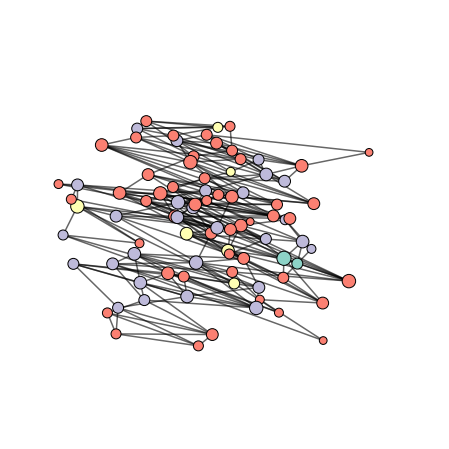

In [120]:
graph_plot.network_plot_3D(G)

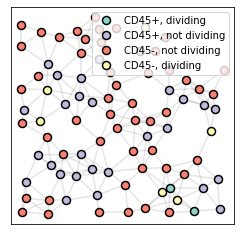

In [105]:
graph_plot.network_plot_2D(G, 
                           scatterpoint_size = 8,
                           alpha_line = 0.1,
                           legend = True,
                           figsize = (4,4))

plt.savefig('tissue_network_subset.pdf')

A first property we would want to access is the distribution of the fraction of neighbours of a given type. To do this, for each node we retrieve
 - the number of neighbours
 - the number of neighbours of each type
 - the nature of the node
 
We return the result as a pandas dataframe object.

In [168]:
from collections import Counter
import networkx as nx

def get_neighbour_properties(G,
                             neighbour_descriptor = 'color'):

    resultframe = pandas.DataFrame()
    i = 0
    
    neighbour_descriptors = nx.get_node_attributes(G, neighbour_descriptor)

    for node in tqdm(G.nodes):
        
        resultframe.loc[i, 'label'] = node
        resultframe.loc[i, neighbour_descriptor] = neighbour_descriptors[node]
        resultframe.loc[i, 'degree'] = len([n for n in G.neighbors(node)])
        
        neighbour_props = [neighbour_descriptors[n] for n in G.neighbors(node)]
        neighbour_props_counter = Counter(neighbour_props)
                
        for key in neighbour_props_counter.keys():
            resultframe.loc[i, key] = neighbour_props_counter[key]
            
        i += 1

    return resultframe.fillna(0)

In [169]:
neighbourhood_props = get_neighbour_properties(G, neighbour_descriptor = 'legend')

  0%|          | 0/2966 [00:00<?, ?it/s]

In [170]:
CD45pn_div = neighbourhood_props[(neighbourhood_props.legend == 'CD45-, dividing') | (neighbourhood_props.legend == 'CD45+, dividing')]

CD45pn_div.mean(axis = 0)

label                  1537.084158
degree                   11.366337
CD45-, not dividing       6.490099
CD45+, not dividing       2.529703
CD45-, dividing           2.079208
CD45+, dividing           0.267327
dtype: float64

In [171]:
neighbourhood_props.mean(axis = 0)

label                  1482.500000
degree                   11.481457
CD45-, not dividing       7.275792
CD45+, not dividing       3.431558
CD45-, dividing           0.668240
CD45+, dividing           0.105866
dtype: float64

<ipython-input-172-6768b7982d6f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CD45pn_div['state'] = 'dividing cells'
<ipython-input-172-6768b7982d6f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CD45pn_div['dividing'] = CD45pn_div['CD45+, dividing'] + CD45pn_div['CD45-, dividing']


Text(0.5, 0, 'number of dividing cells as neighbours')

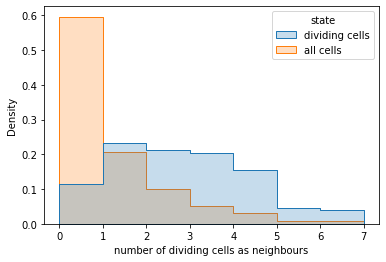

In [172]:
import seaborn as sns

CD45pn_div['state'] = 'dividing cells'
CD45pn_div['dividing'] = CD45pn_div['CD45+, dividing'] + CD45pn_div['CD45-, dividing']

neighbourhood_props['state'] = 'all cells'
neighbourhood_props['dividing'] = neighbourhood_props['CD45+, dividing'] + neighbourhood_props['CD45-, dividing']

histframe = CD45pn_div.append(neighbourhood_props)

fig, ax = plt.subplots()

sns.histplot(
    histframe, x="dividing", hue="state", element="step",
    stat="density", common_norm=False, binwidth=1
)

ax.set_xlabel('number of dividing cells as neighbours')

<ipython-input-173-a79a973dc78e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CD45p['state'] = 'CD45+'
<ipython-input-173-a79a973dc78e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CD45p['CD45+'] = CD45p['CD45+, dividing'] + CD45p['CD45+, not dividing']


Text(0.5, 0, 'number of CD45+ cells as neighbours')

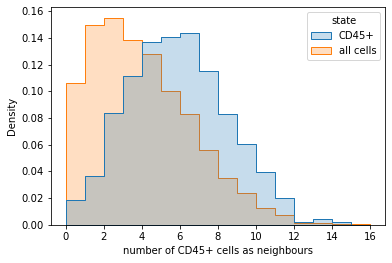

In [173]:
import seaborn as sns
CD45p = neighbourhood_props[(neighbourhood_props.legend == 'CD45+, not dividing') | (neighbourhood_props.legend == 'CD45+, dividing')]

CD45p['state'] = 'CD45+'
CD45p['CD45+'] = CD45p['CD45+, dividing'] + CD45p['CD45+, not dividing']

neighbourhood_props['state'] = 'all cells'
neighbourhood_props['CD45+'] = neighbourhood_props['CD45+, dividing'] + neighbourhood_props['CD45+, not dividing']

histframe = CD45p.append(neighbourhood_props)

fig, ax = plt.subplots()

sns.histplot(
    histframe, x="CD45+", hue="state", element="step",
    stat="density", common_norm=False, binwidth=1
)

ax.set_xlabel('number of CD45+ cells as neighbours')

### Finding clusters of"rare" cells

We have shown that dividing cells tend to cluster together. Let's now find the positions of the most important cell division clusters in the sample.

In [174]:
node_list = []

for x, y in G.nodes(data=True):
    
    if (y['legend'] == 'CD45-, dividing') | (y['legend'] == 'CD45+, dividing'):
        
        node_list.append(x)
                
dividing_cells_graph = G.subgraph(node_list)

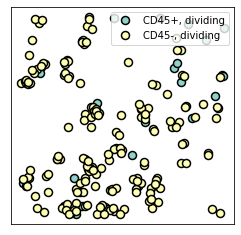

In [175]:
graph_plot.network_plot_2D(dividing_cells_graph, 
                           scatterpoint_size = 8,
                           alpha_line = 0.1,
                           legend = True,
                           figsize = (4,4))

In [177]:
S = [dividing_cells_graph.subgraph(c).copy() for c in nx.connected_components(dividing_cells_graph)]

In [179]:
def get_cluster_properties(subgraph):
    
    resultframe = pandas.DataFrame()
    i = 0
    
    S = [subgraph.subgraph(c).copy() for c in nx.connected_components(subgraph)]
    
    for s in S:
        
        pos = nx.get_node_attributes(s, 'pos')
        
        resultframe.loc[i, 'x'] = np.mean([pos[key][1] for key in pos.keys()])
        resultframe.loc[i, 'y'] = np.mean([pos[key][2] for key in pos.keys()])
        resultframe.loc[i, 'cluster_size'] = len(s)
        i += 1
        
    return resultframe

In [186]:
cluster_props = get_cluster_properties(dividing_cells_graph)

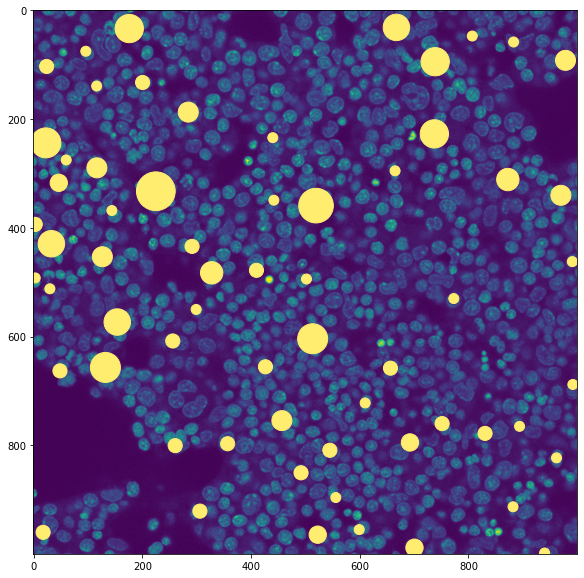

In [194]:
fig, ax  = plt.subplots(figsize = (10,10))
plt.imshow(total_image[25, :1000, :1000, 2])
plt.scatter(cluster_props.y,
            cluster_props.x,
            c = plt.cm.Set3(cluster_props.cluster_size),
            s = 100*cluster_props.cluster_size)